In [ ]:
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

## Przygotowanie danych

In [ ]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),])
                                #transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root="data/", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10,10+num)], dim=0)

In [ ]:
next(iter(train_dataset))[0].max()

# Budowanie autoenkodera
Generalnie autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z** oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Przykład w oparciu o https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

Zacznijmy od stworzenia enkodera

In [ ]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

### Dekoder
Dekoder jest lustrzanym odbiciem enkodera, w związku z tym musimy zastosować operację odwrotną do konwolucji, jak mogłaby ona wyglądać?

In [ ]:
conv_t = nn.ConvTranspose2d(1,1,kernel_size=2,bias=False)

In [ ]:
torch.ones([1,1,3,3])

In [ ]:
conv_t.weight

In [ ]:
conv_t(torch.ones([1,1,3,3]))

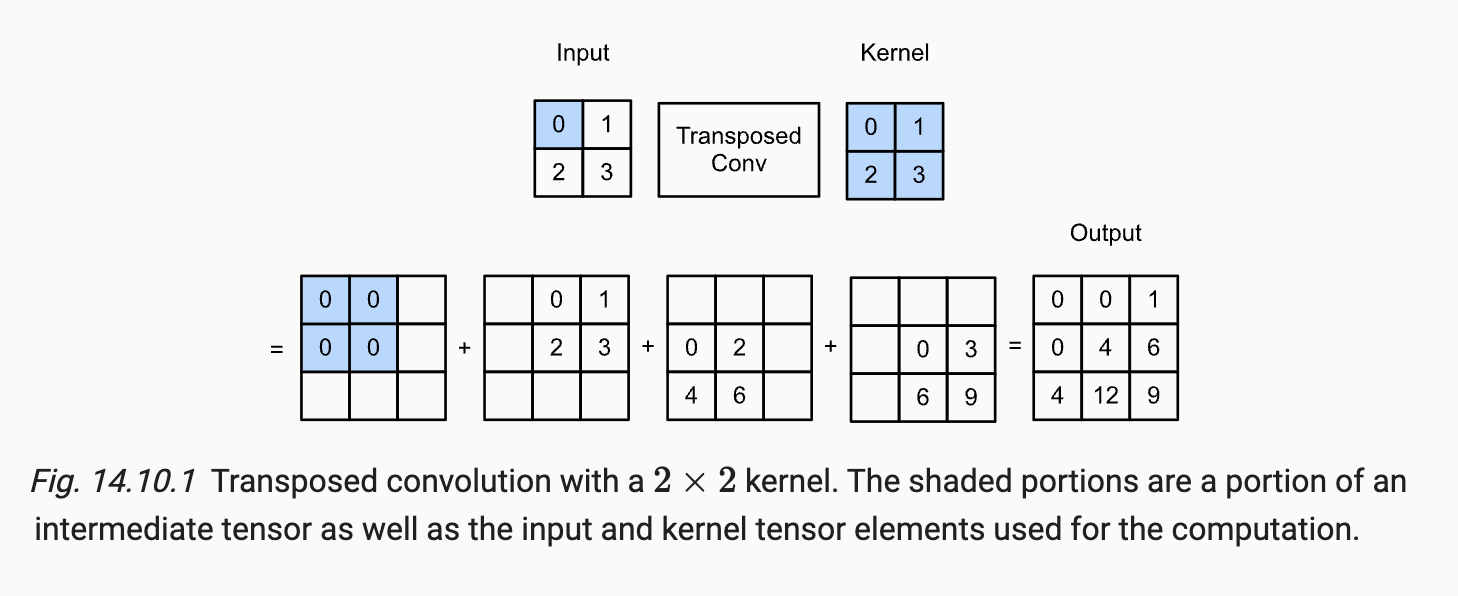

In [ ]:
conv_t = nn.ConvTranspose2d(1,1,kernel_size=2,bias=False, output_padding=1,padding=1,stride=2)
conv_t(torch.ones([1,1,3,3]))

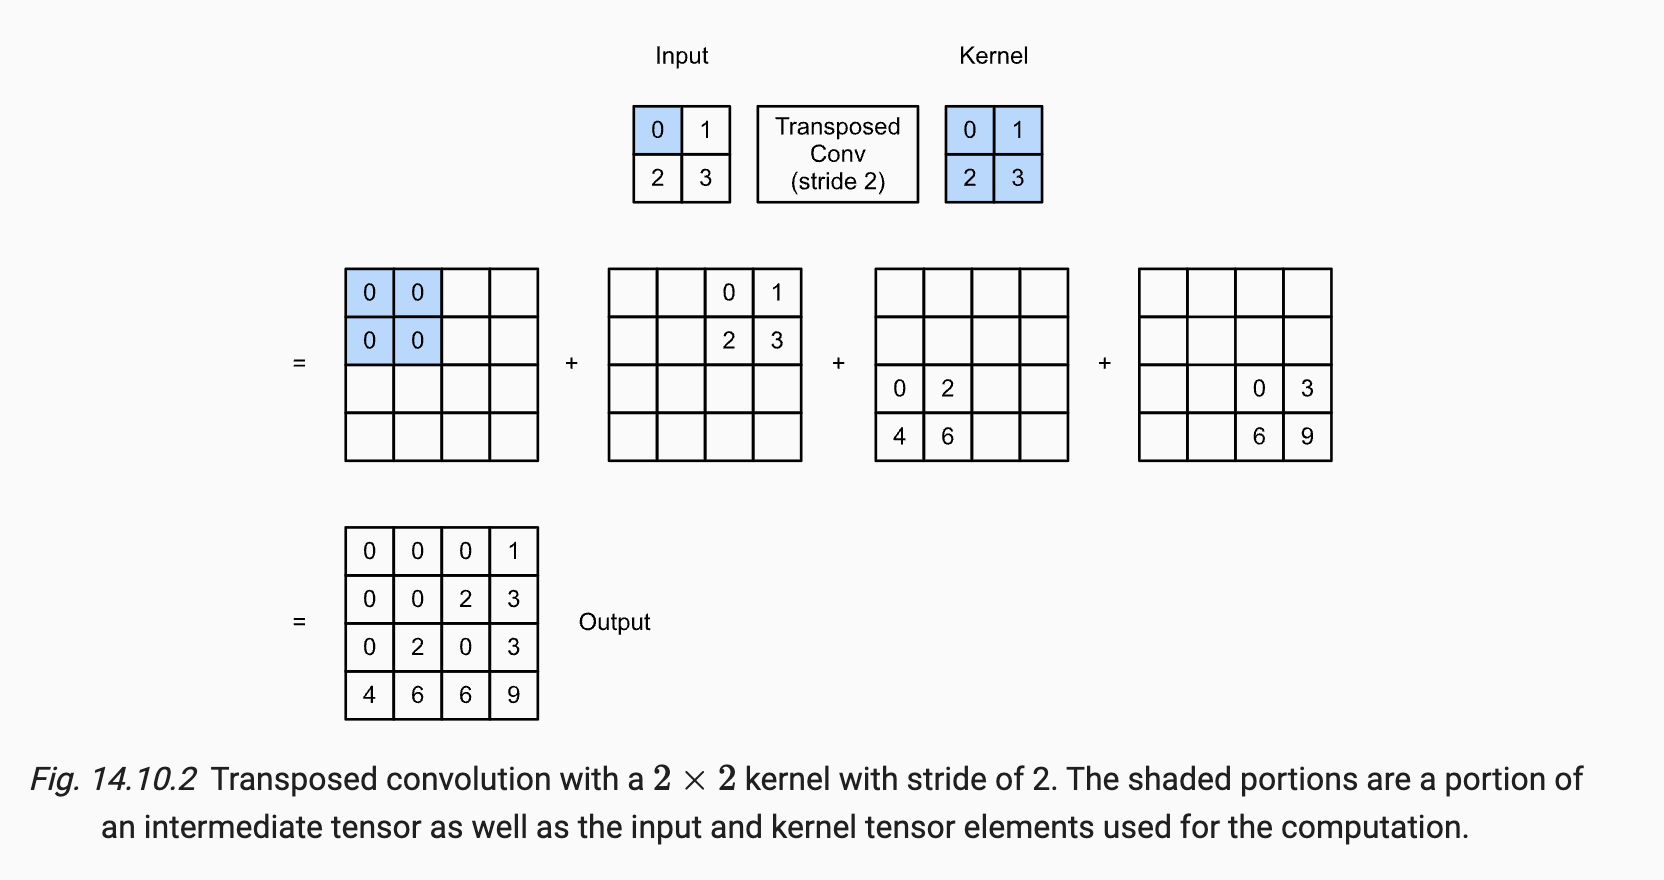

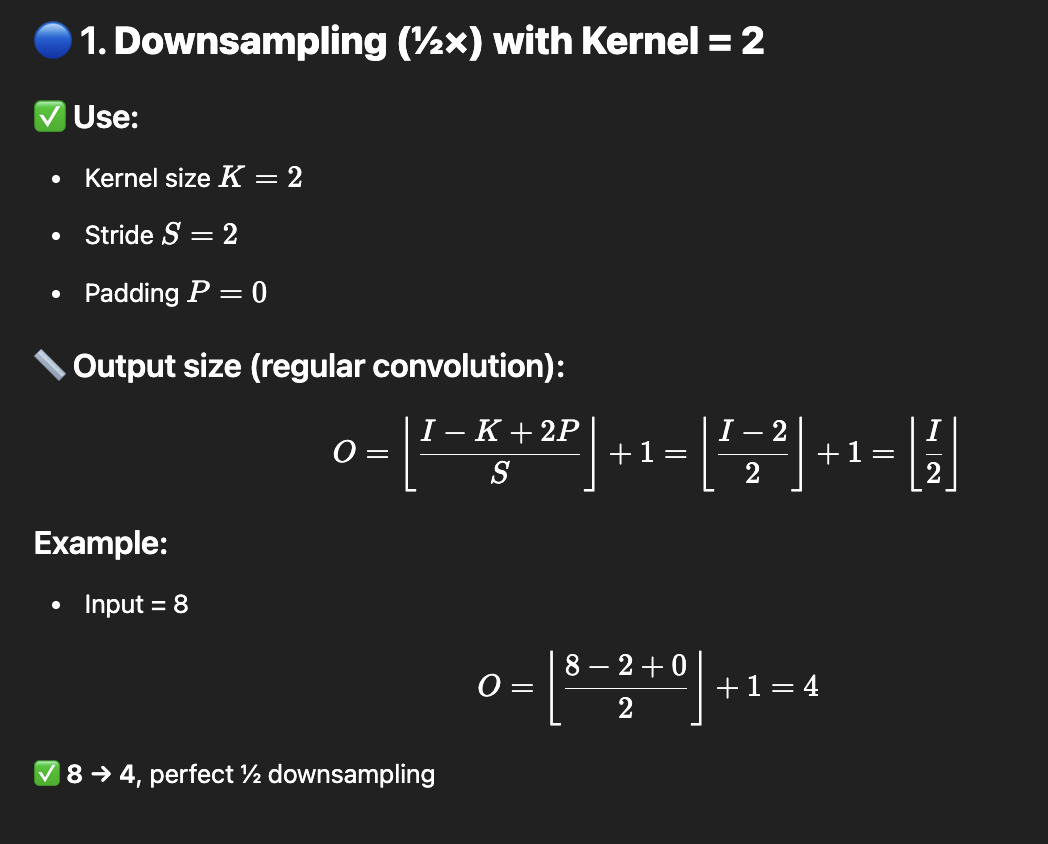

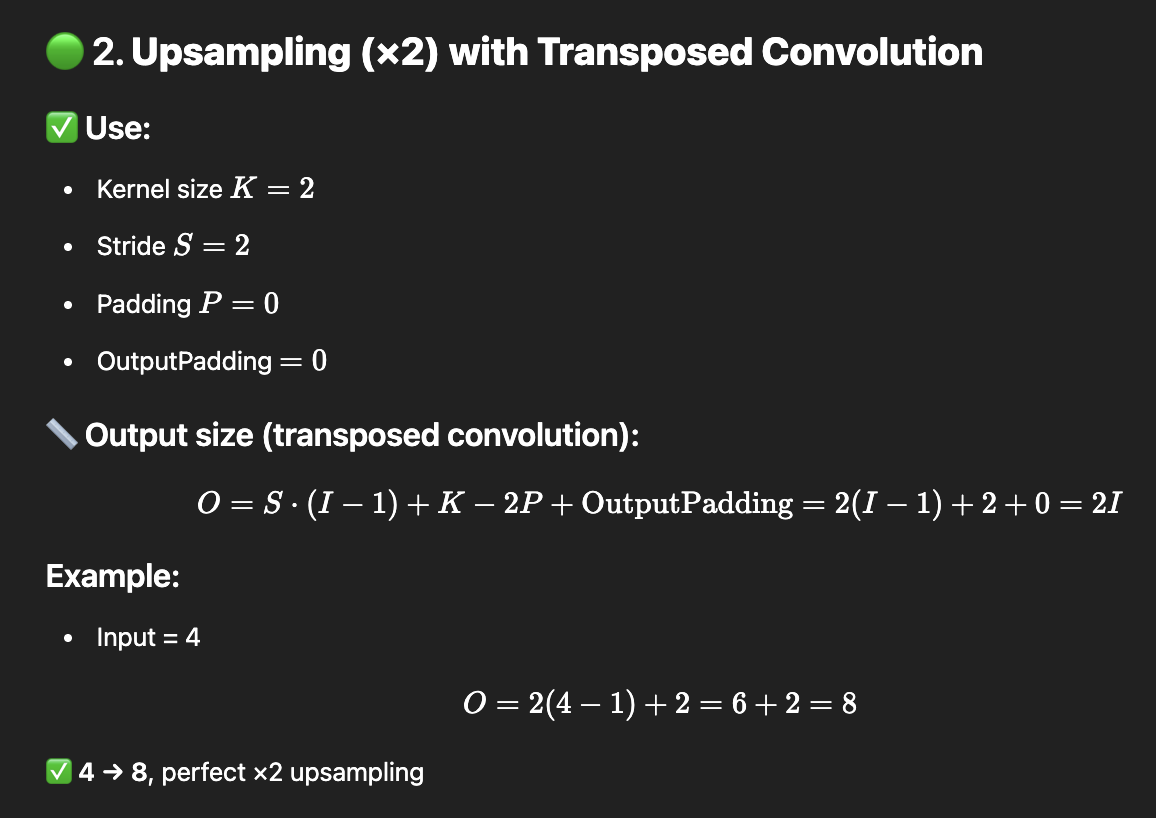

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## Połączmy enkoder z dekoderem

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

## Trenowanie modelu
Jako funkcję straty wykorzystamy MSE pomiędzy oryginalnymi, a rekonstruowanymi pikselami. Jakie może to powodować problemy?

In [ ]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Inne funkcje straty dla autoenkoderów:
- Adwersarialna funkcja straty (na następnych zajęciach)
- Funkcje straty w oparciu o transformaty (np. Laplacian piramid loss)

## Laplacian piramid loss
Tworzymy Piramidę Laplace’a dla oryginalnego i wygenerowanego obrazu.
Piramida Laplace’a  to zestaw obrazów od pełnej rozdzielczości do coraz niższej, przy czym na każdym poziomie wyciągamy szczegóły z danego poziomu (obliczając różnice między kolejnymi poziomami).

Obliczamy stratę (np. L1) na każdym poziomie piramidy.

Sumujemy wszystkie poziomy jako końcową stratę.



In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
# num_epochs = 100
# for n in range(num_epochs):
#     losses_epoch = []
#     for x, _ in iter(train_loader):
#         x = x.to(device)
#         out = autoencoder(x)
#         loss = criterion(out, x)
#         losses_epoch.append(loss.item())
#         loss.backward()               # backward pass (compute parameter updates)
#         optimizer.step()              # make the updates for each parameter
#         optimizer.zero_grad()
#     L1_list = []
# #     if n % 10 == 0:
#     for x, _ in iter(test_loader):
#         x  = x.to(device)
#         out = autoencoder(x)
#         L1_list.append(torch.mean(torch.abs(out-x)).item())
#     print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
#     scheduler.step()

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_128")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("autoencoder_128"))

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(0,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

# Większa przestrzeń ukryta

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
# num_epochs = 100
# for n in range(num_epochs):
#     losses_epoch = []
#     for x, _ in iter(train_loader):
#         x = x.to(device)
#         out = autoencoder(x)
#         loss = criterion(out, x)
#         losses_epoch.append(loss.item())
#         loss.backward()               # backward pass (compute parameter updates)
#         optimizer.step()              # make the updates for each parameter
#         optimizer.zero_grad()
#     L1_list = []
# #     if n % 10 == 0:
#     for x, _ in iter(test_loader):
#         x  = x.to(device)
#         out = autoencoder(x)
#         L1_list.append(torch.mean(torch.abs(out-x)).item())
#     print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
#     scheduler.step()

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_256")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("autoencoder_256"))

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
# num_epochs = 100
# for n in range(num_epochs):
#     losses_epoch = []
#     for x, _ in iter(train_loader):
#         x = x.to(device)
#         out = autoencoder(x)
#         loss = criterion(out, x)
#         losses_epoch.append(loss.item())
#         loss.backward()               # backward pass (compute parameter updates)
#         optimizer.step()              # make the updates for each parameter
#         optimizer.zero_grad()
#     L1_list = []
# #     if n % 10 == 0:
#     for x, _ in iter(test_loader):
#         x  = x.to(device)
#         out = autoencoder(x)
#         L1_list.append(torch.mean(torch.abs(out-x)).item())
#     print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
#     scheduler.step()

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_512")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("autoencoder_512"))

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
input_imgs = get_train_images(8)
for latent in [128,256,512]:
    autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(device)
    autoencoder.load_state_dict(torch.load(f"autoencoder_{latent}"))
    visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
latent = 256
autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load(f"autoencoder_{latent}"))

# Czy jesteśmy w stanie wszystko zrekonstruować z podobną skutecznością?

In [ ]:
rand_imgs = torch.rand(4, 3, 32, 32) * 2 - 1
visualize_reconstructions(autoencoder, rand_imgs, device)

In [ ]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1,0] = 1
# Checkboard pattern
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

visualize_reconstructions(autoencoder, plain_imgs, device)

# Generowanie nowych obrazków
Skoro mamy reprezentacje ukryte, to możemy wylosować dowolny wektor i odtworzyć nowy obrazek?

In [ ]:
latent_vectors = torch.randn(8, latent, device=device)
with torch.no_grad():
    imgs = autoencoder.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(0,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()


### Jak to poprawić?

# Przestrzeń ukryta autoenkodera

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            z = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(z)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

train_img_embeds = embed_imgs(autoencoder, train_loader)
test_img_embeds = embed_imgs(autoencoder, test_loader)

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img.unsqueeze(0).cpu(), key_embeds[0][indices.cpu()[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

## Wizualizacja przestrzeni ukrytej

In [ ]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
umap = umap.UMAP(metric="cosine", n_neighbors=100)

In [ ]:
train_embedded = umap.fit_transform(train_img_embeds[1][:5000].cpu())

In [ ]:
data = pd.DataFrame(train_embedded)

In [ ]:
data["label"] = train_img_embeds[2][:5000].cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)
plt.show();

In [ ]:
examples = []
examples_locations = []
for i in np.random.randint(0,5000,40):
    examples.append(train_img_embeds[0][i].cpu().numpy())
    examples_locations.append(data.iloc[i])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.1
)
for location, example in zip(examples_locations, examples):
    x, y = location[0], location[1]
    label = int(location["label"])
    ab = AnnotationBbox(OffsetImage(np.swapaxes(np.swapaxes(example,0,1),1,2), zoom=1), (x, y), frameon=True,
                        bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    ax.add_artist(ab)
plt.show()

# Wykrywanie nietypowych obrazków w oparciu o reprezentacje

In [ ]:
dist = torch.cdist(train_img_embeds[1].cpu(), train_img_embeds[1].cpu(), p=2)

In [ ]:
outliers = torch.sort(dist.sum(0))[1][-5:].cpu()
imgs_to_display = train_img_embeds[0][outliers]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, value_range=(0,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)
plt.show();

In [ ]:
most_usual = torch.sort(dist.sum(0))[1][:5].cpu()
imgs_to_display = train_img_embeds[0][most_usual]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, value_range=(0,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)
plt.show();

# Autoenkoder wariacyjny

In [ ]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

In [ ]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

# Budowanie autoenkodera wariacyjnego
VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Zacznijmy od stworzenia enkodera

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat


### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
#        z ~N(mean, var) Change to proper sampling
        z = mean
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [ ]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [ ]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(generated_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
generate_images(vae, 16 , device)

## Co poszło nie tak?

In [ ]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
generate_images(vae, 16 , device)

# Przestrzeń ukryta VAE

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [ ]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [ ]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
generate_images(vae, 16 , device)

In [ ]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)
plt.show()